Feature Analysis:
pumin1_4u_Qtransformed:
  Correlation with target: -0.0375
  Mutual Information Score: 0.0582
pumin5_8u_Qtransformed:
  Correlation with target: -0.0195
  Mutual Information Score: 0.0000
pumin1_4d_Qtransformed:
  Correlation with target: 0.2151
  Mutual Information Score: 0.0000
pumin5_8d_Qtransformed:
  Correlation with target: 0.1430
  Mutual Information Score: 0.0292
Pu1_1_BoxCox:
  Correlation with target: 0.1231
  Mutual Information Score: 0.0862
Pu2_1_log:
  Correlation with target: 0.1189
  Mutual Information Score: 0.0614
seedNumber_1_Ytransformed:
  Correlation with target: 0.2940
  Mutual Information Score: 0.0793
seedNumber_3_Ytransformed:
  Correlation with target: 0.1270
  Mutual Information Score: 0.0276
E_1_log:
  Correlation with target: -0.1604
  Mutual Information Score: 0.1199
E_3_BoxCox:
  Correlation with target: -0.0948
  Mutual Information Score: 0.0363
ED2_3_Ytransformed:
  Correlation with target: -0.1659
  Mutual Information Score: 0.0057
E_

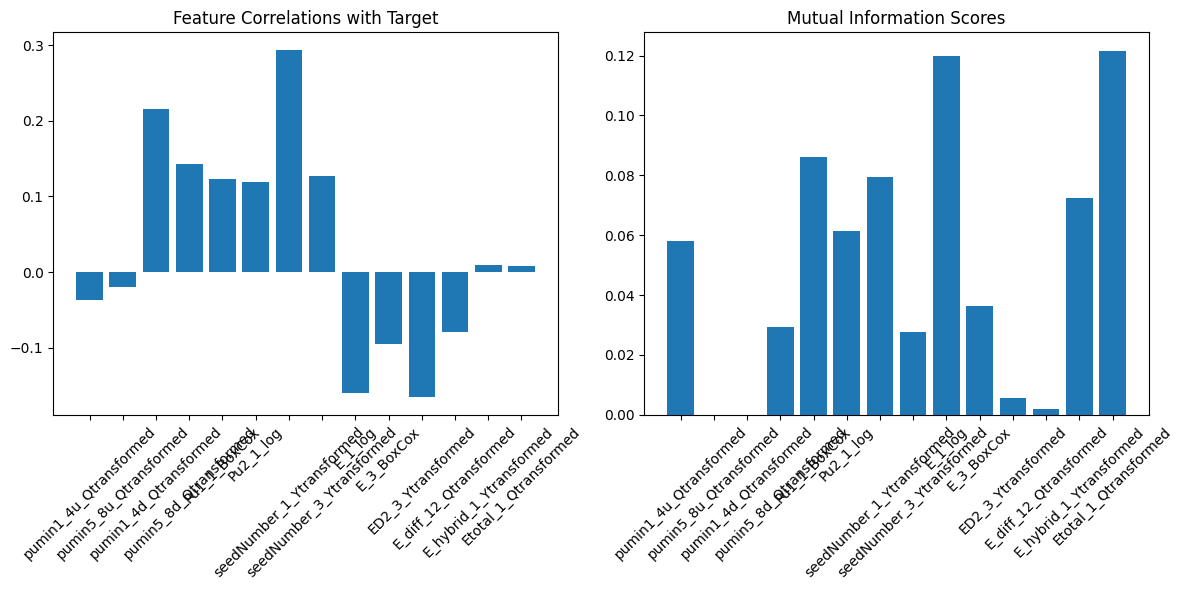

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_analyze_data(file_path):
    # Load data
    data = pd.read_csv(file_path)
    X = data.drop('Y', axis=1)
    y = data['Y']
    
    # Analyze feature correlations with target
    correlations = {}
    for column in X.columns:
        correlations[column] = np.corrcoef(X[column], y)[0, 1]
    
    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X, y)
    feature_importance = dict(zip(X.columns, mi_scores))
    
    return data, X, y, correlations, feature_importance

def preprocess_data(X, y):
    # Try different scalers
    scalers = {
        'standard': StandardScaler(),
        'robust': RobustScaler()
    }
    
    scaled_data = {}
    for name, scaler in scalers.items():
        scaled_data[name] = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=0.95)  # Preserve 95% of variance
    pca_data = pca.fit_transform(scaled_data['robust'])
    
    return scaled_data, pca_data, pca

def select_features(X, y):
    # Use Random Forest for feature selection
    rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
    selector = SelectFromModel(rf_selector, prefit=False)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.get_support()].tolist()
    X_selected = selector.transform(X)
    
    return X_selected, selected_features

def optimize_random_forest(X, y):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_params_

def evaluate_and_visualize(X, y, correlations, feature_importance):
    plt.figure(figsize=(12, 6))
    
    # Plot feature correlations
    plt.subplot(1, 2, 1)
    correlation_values = list(correlations.values())
    plt.bar(range(len(correlations)), correlation_values)
    plt.xticks(range(len(correlations)), list(correlations.keys()), rotation=45)
    plt.title('Feature Correlations with Target')
    
    # Plot mutual information scores
    plt.subplot(1, 2, 2)
    mi_values = list(feature_importance.values())
    plt.bar(range(len(feature_importance)), mi_values)
    plt.xticks(range(len(feature_importance)), list(feature_importance.keys()), rotation=45)
    plt.title('Mutual Information Scores')
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and analyze data
    data, X, y, correlations, feature_importance = load_and_analyze_data('data_transformed.csv')
    
    # Print initial analysis
    print("Feature Analysis:")
    for feature in X.columns:
        print(f"{feature}:")
        print(f"  Correlation with target: {correlations[feature]:.4f}")
        print(f"  Mutual Information Score: {feature_importance[feature]:.4f}")
    
    # Preprocess data
    scaled_data, pca_data, pca = preprocess_data(X, y)
    
    # Select features
    X_selected, selected_features = select_features(X, y)
    print("\nSelected Features:", selected_features)
    
    # Try different approaches
    approaches = {
        'Original Scaled': scaled_data['robust'],
        'PCA': pca_data,
        'Selected Features': X_selected
    }
    
    for name, X_transformed in approaches.items():
        print(f"\nTesting {name} approach:")
        
        # Optimize Random Forest
        best_rf, best_params = optimize_random_forest(X_transformed, y)
        
        # Evaluate with cross-validation
        cv_scores = cross_val_score(best_rf, X_transformed, y, cv=5, scoring='r2')
        mse_scores = -cross_val_score(best_rf, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
        
        print(f"Best Parameters: {best_params}")
        print(f"Mean R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"Mean MSE: {mse_scores.mean():.4f} (±{mse_scores.std():.4f})")
    
    # Visualize results
    evaluate_and_visualize(X, y, correlations, feature_importance)

if __name__ == "__main__":
    main()